In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 165

ng =18

ng_refs = (/ 18 /) 

nref =1

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 500 /) 

t_refs = (/ 250 /) 

tsfc =294

vstar = 1215

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

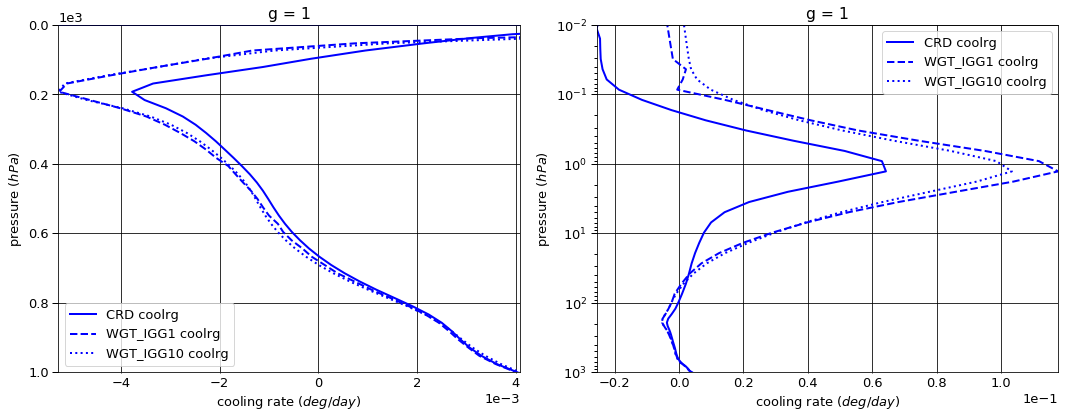

# Figure: cooling rate g-group 2

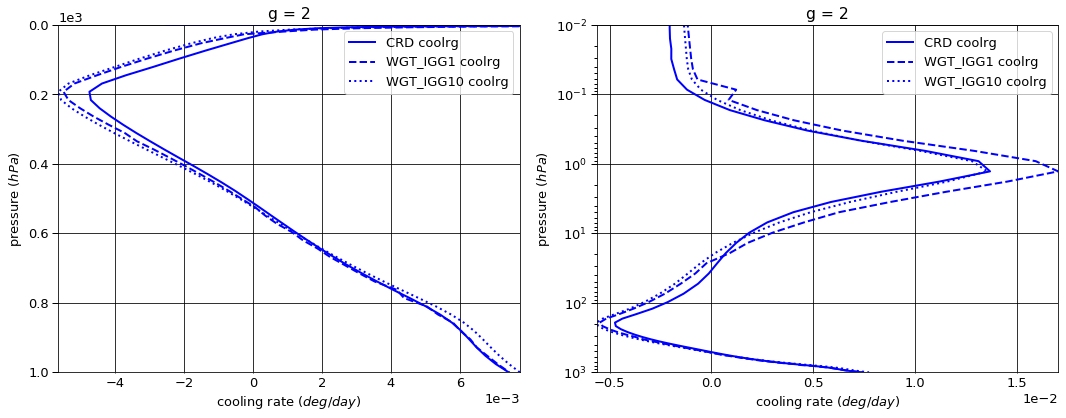

# Figure: cooling rate g-group 3

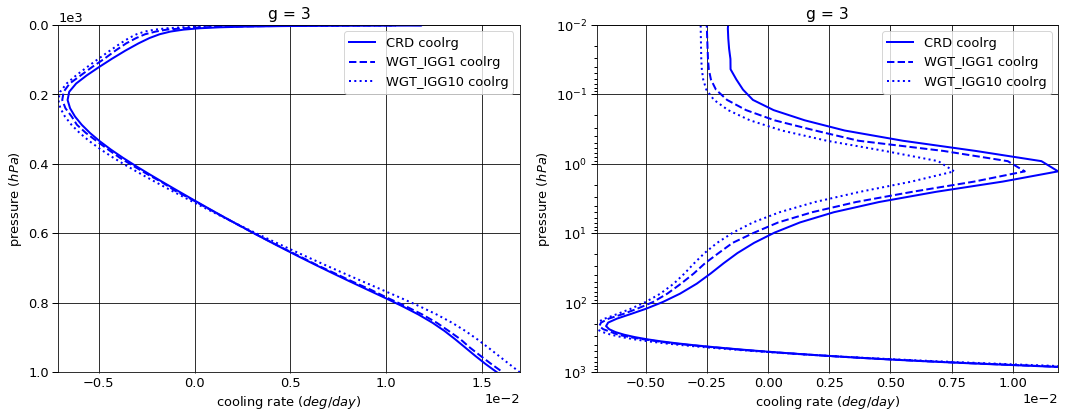

# Figure: cooling rate g-group 4

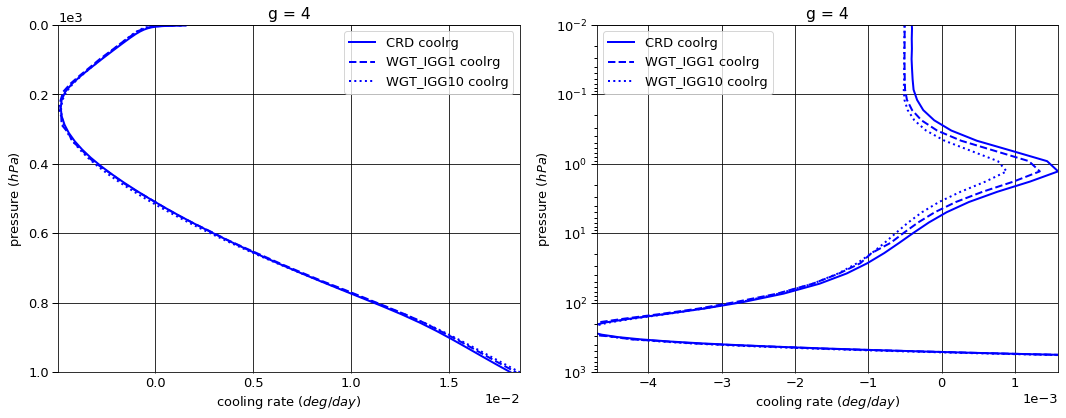

# Figure: cooling rate g-group 5

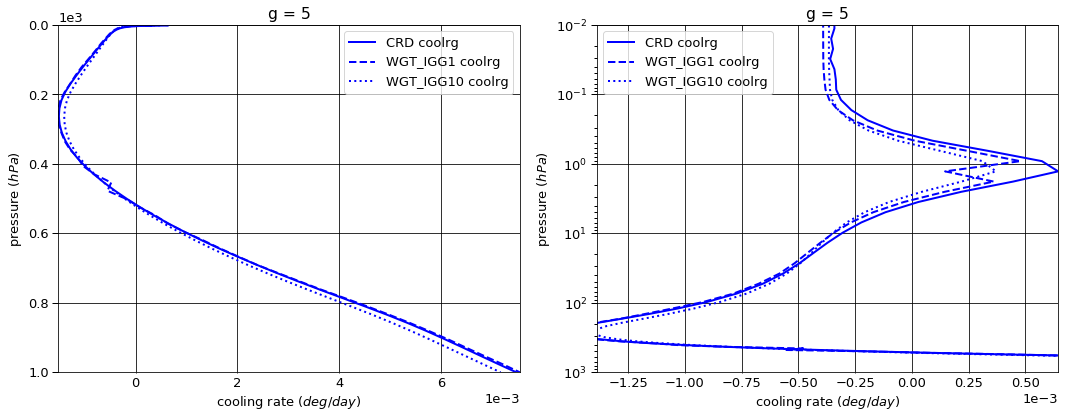

# Figure: cooling rate g-group 6

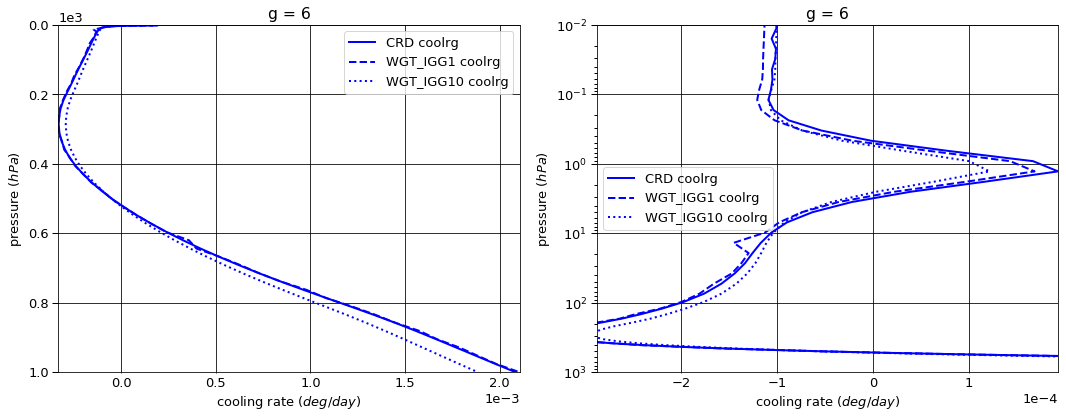

# Figure: cooling rate g-group 7

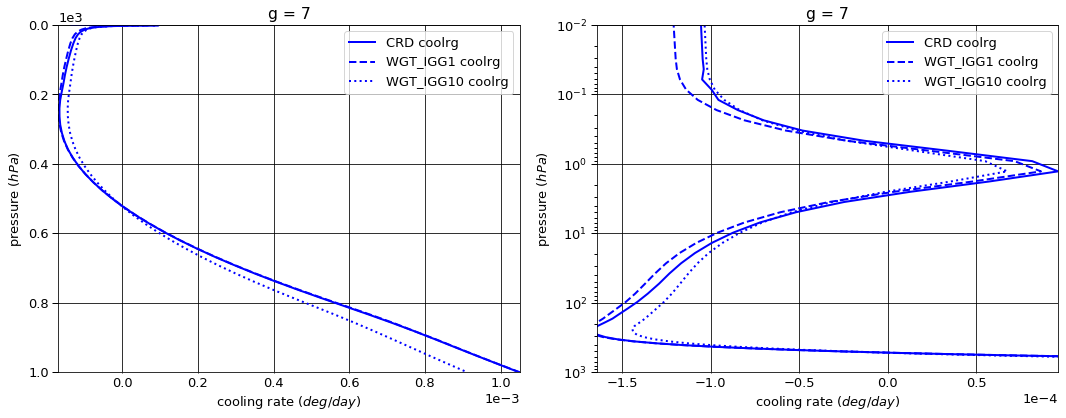

# Figure: cooling rate g-group 8

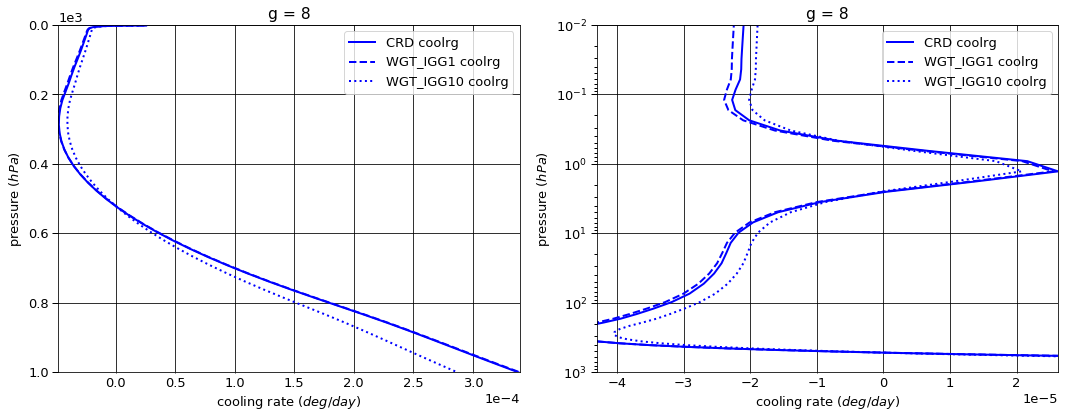

# Figure: cooling rate g-group 9

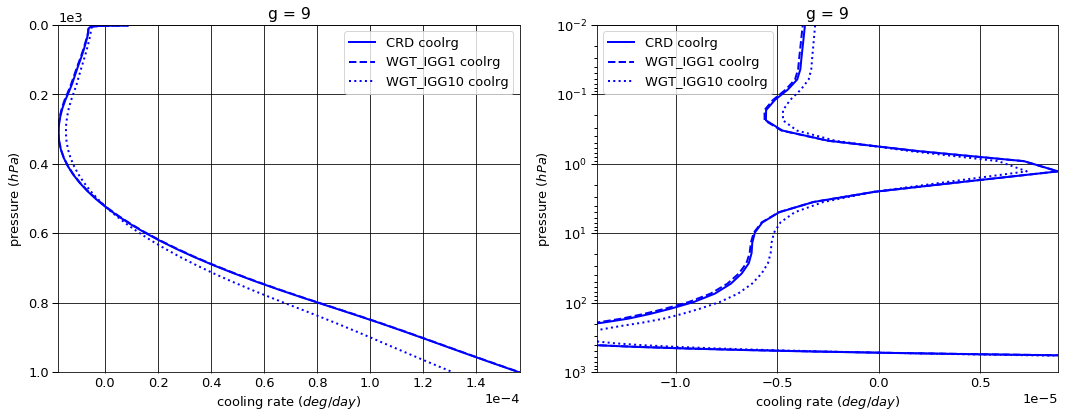

# Figure: cooling rate g-group 10

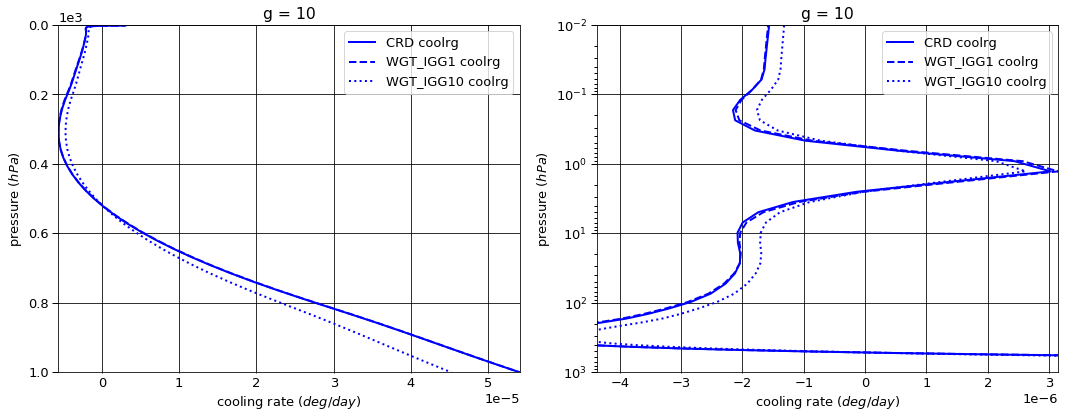

# Figure: cooling rate g-group 11

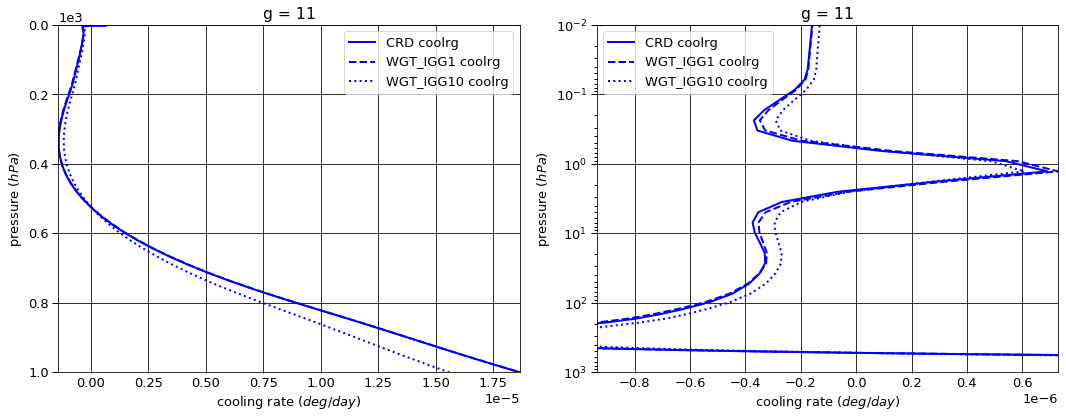

# Figure: cooling rate g-group 12

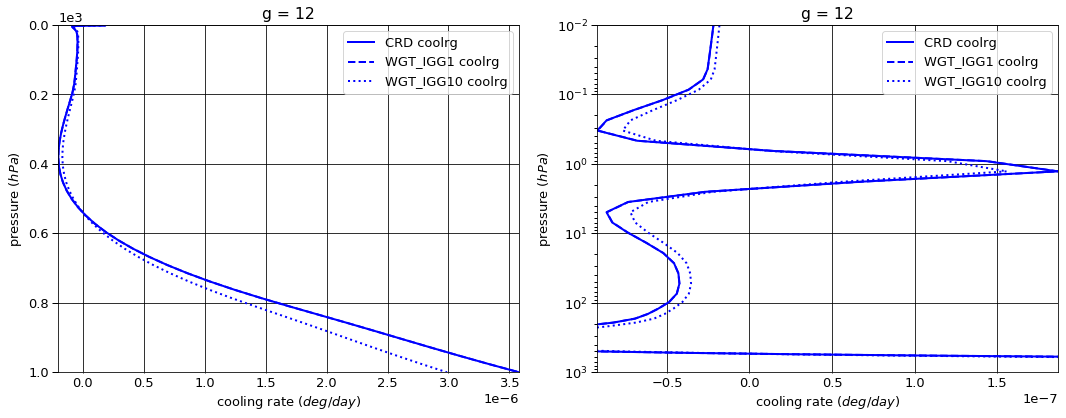

# Figure: cooling rate g-group 13

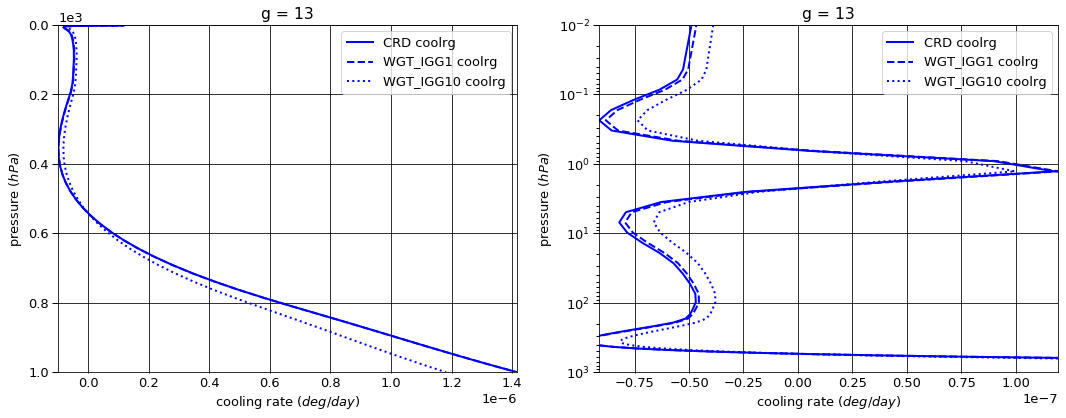

# Figure: cooling rate g-group 14

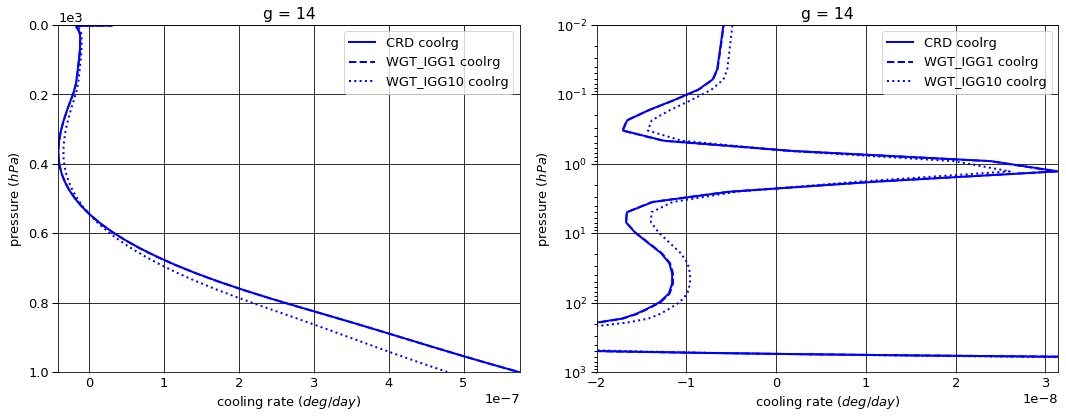

# Figure: cooling rate g-group 15

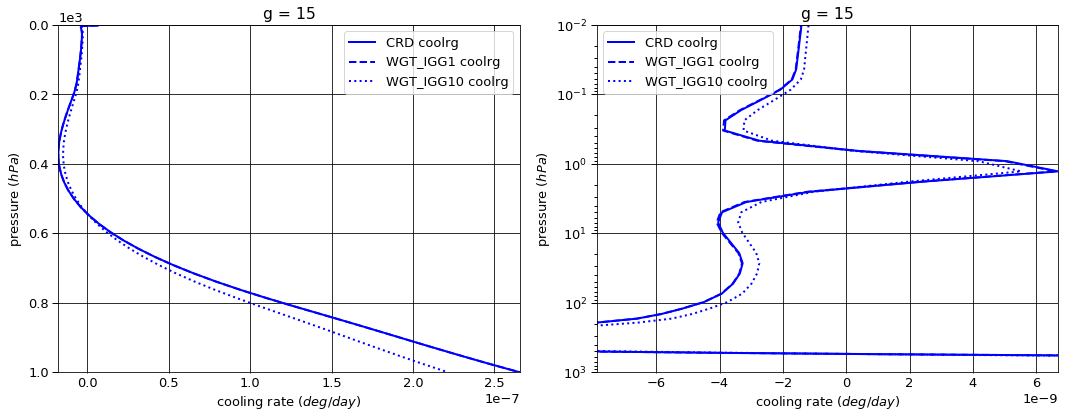

# Figure: cooling rate g-group 16

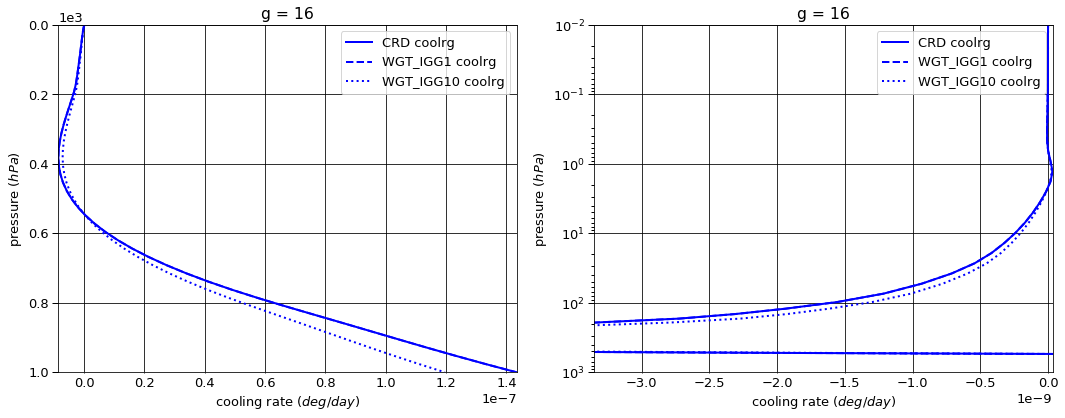

# Figure: cooling rate g-group 17

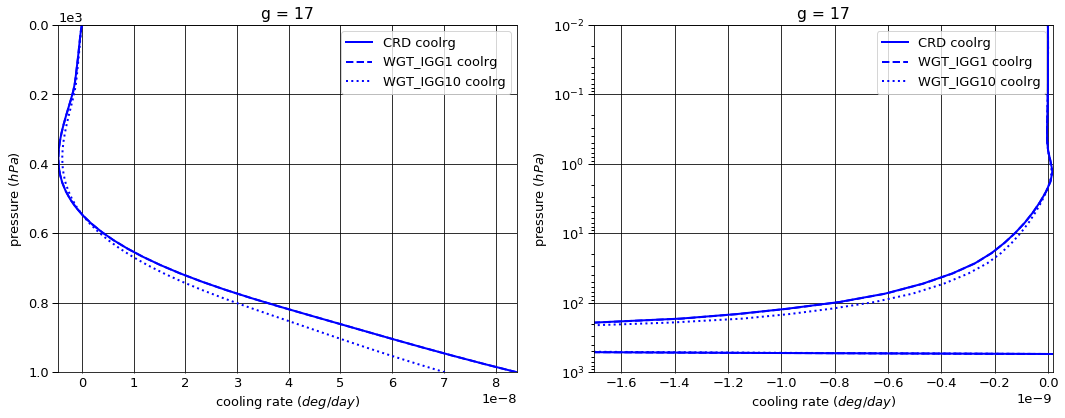

# Figure: cooling rate g-group 18

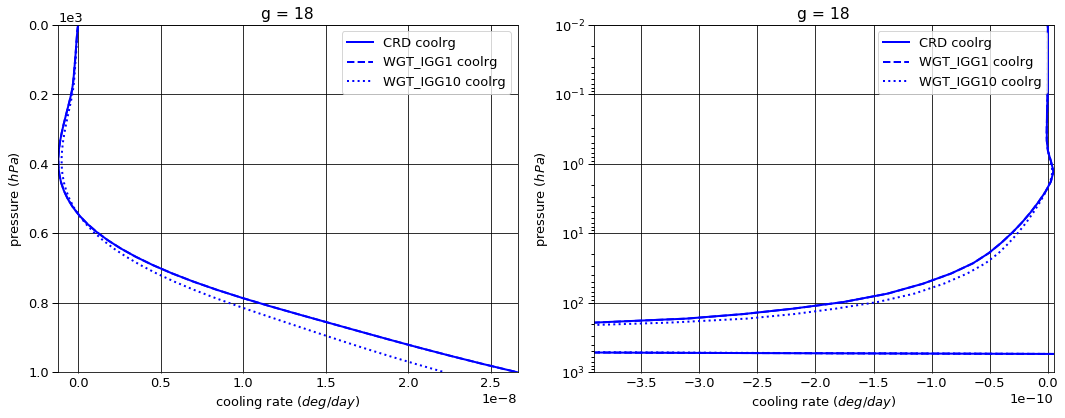

# Figure: cooling rate g-group total

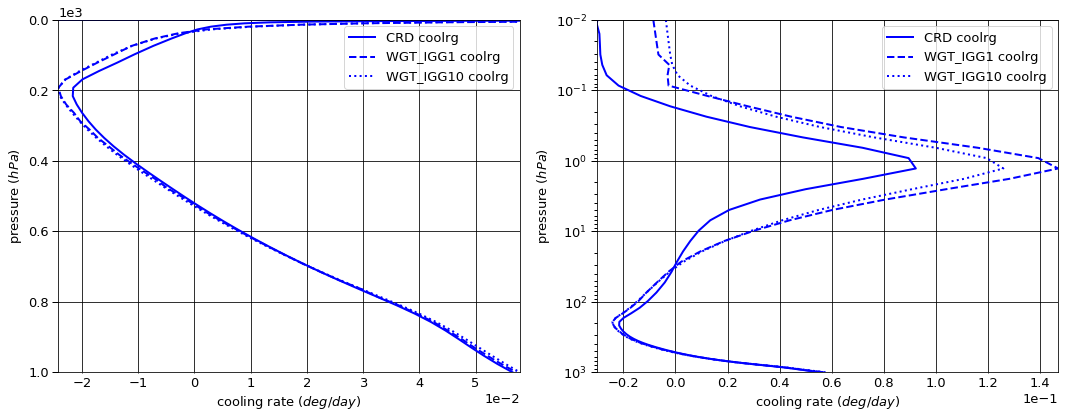

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug          fldg     fnetg
g  pressure level                                  
1  0.0      1     -0.119274  0.000000e+00 -0.119274
   1013.0   76    -0.646776  5.496757e-01 -0.097100
2  0.0      1     -0.393697  0.000000e+00 -0.393697
   1013.0   76    -1.028436  7.286645e-01 -0.299771
3  0.0      1     -1.486395  0.000000e+00 -1.486395
   1013.0   76    -2.305115  1.091975e+00 -1.213139
4  0.0      1     -2.982460  0.000000e+00 -2.982460
   1013.0   76    -3.600236  9.911966e-01 -2.609040
5  0.0      1     -2.345396  0.000000e+00 -2.345396
   1013.0   76    -2.546053  3.570693e-01 -2.188983
6  0.0      1     -1.399862  0.000000e+00 -1.399862
   1013.0   76    -1.446667  9.182443e-02 -1.354843
7  0.0      1     -1.747309  0.000000e+00 -1.747309
   1013.0   76    -1.770654  4.444387e-02 -1.726210
8  0.0      1     -1.455820  0.000000e+00 -1.455820
   1013.0   76    -1.462652  1.397792e-02 -1.448674
9  0.0      1     -1.472902  0.000000e+00 -1.472902
   1013.0   76    -1.475610  6.158363e-03 -1.469451
10 0.0      1     -1.424548  0.000000e+00 -1.424548
   1013.0   76    -1.425439  2.100678e-03 -1.423338
11 0.0      1     -0.917381  0.000000e+00 -0.917381
   1013.0   76    -0.917632  6.697021e-04 -0.916962
12 0.0      1     -0.341374  0.000000e+00 -0.341374
   1013.0   76    -0.341414  1.187660e-04 -0.341296
13 0.0      1     -0.463257  0.000000e+00 -0.463257
   1013.0   76    -0.463275  4.796861e-05 -0.463227
14 0.0      1     -0.512893  0.000000e+00 -0.512893
   1013.0   76    -0.512901  1.972659e-05 -0.512881
15 0.0      1     -0.649090  0.000000e+00 -0.649090
   1013.0   76    -0.649094  9.011095e-06 -0.649085
16 0.0      1     -0.917645  0.000000e+00 -0.917645
   1013.0   76    -0.917647  4.726862e-06 -0.917642
17 0.0      1     -1.304349  0.000000e+00 -1.304349
   1013.0   76    -1.304350  2.695092e-06 -1.304347
18 0.0      1     -0.941228  0.000000e+00 -0.941228
   1013.0   76    -0.941228  8.218143e-07 -0.941227


WGT_IGG1


flug          fldg     fnetg
g  pressure level                                  
1  0.0      1     -0.119580  0.000000e+00 -0.119580
   1013.0   76    -0.646776  5.535687e-01 -0.093207
2  0.0      1     -0.350653  0.000000e+00 -0.350653
   1013.0   76    -1.028436  7.416820e-01 -0.286753
3  0.0      1     -1.457628  0.000000e+00 -1.457628
   1013.0   76    -2.305115  1.111134e+00 -1.193980
4  0.0      1     -2.974029  0.000000e+00 -2.974029
   1013.0   76    -3.600236  1.002799e+00 -2.597437
5  0.0      1     -2.343953  0.000000e+00 -2.343953
   1013.0   76    -2.546053  3.595888e-01 -2.186464
6  0.0      1     -1.399647  0.000000e+00 -1.399647
   1013.0   76    -1.446667  9.223562e-02 -1.354432
7  0.0      1     -1.747119  0.000000e+00 -1.747119
   1013.0   76    -1.770654  4.453389e-02 -1.726120
8  0.0      1     -1.455809  0.000000e+00 -1.455809
   1013.0   76    -1.462652  1.400363e-02 -1.448648
9  0.0      1     -1.472908  0.000000e+00 -1.472908
   1013.0   76    -1.475610  6.162856e-03 -1.469447
10 0.0      1     -1.424550  0.000000e+00 -1.424550
   1013.0   76    -1.425439  2.101144e-03 -1.423337
11 0.0      1     -0.917381  0.000000e+00 -0.917381
   1013.0   76    -0.917632  6.697575e-04 -0.916962
12 0.0      1     -0.341374  0.000000e+00 -0.341374
   1013.0   76    -0.341414  1.187694e-04 -0.341296
13 0.0      1     -0.463257  0.000000e+00 -0.463257
   1013.0   76    -0.463275  4.796956e-05 -0.463227
14 0.0      1     -0.512893  0.000000e+00 -0.512893
   1013.0   76    -0.512901  1.972675e-05 -0.512881
15 0.0      1     -0.649090  0.000000e+00 -0.649090
   1013.0   76    -0.649094  9.011117e-06 -0.649085
16 0.0      1     -0.917645  0.000000e+00 -0.917645
   1013.0   76    -0.917647  4.726865e-06 -0.917642
17 0.0      1     -1.304349  0.000000e+00 -1.304349
   1013.0   76    -1.304350  2.695092e-06 -1.304347
18 0.0      1     -0.941228  0.000000e+00 -0.941228
   1013.0   76    -0.941228  8.218144e-07 -0.941227


WGT_IGG10


flug          fldg     fnetg
g  pressure level                                  
1  0.0      1     -0.114895  0.000000e+00 -0.114895
   1013.0   76    -0.646776  5.622941e-01 -0.084482
2  0.0      1     -0.329793  0.000000e+00 -0.329793
   1013.0   76    -1.028436  7.616186e-01 -0.266817
3  0.0      1     -1.461983  0.000000e+00 -1.461983
   1013.0   76    -2.305115  1.118970e+00 -1.186145
4  0.0      1     -3.012178  0.000000e+00 -3.012178
   1013.0   76    -3.600236  9.615347e-01 -2.638702
5  0.0      1     -2.365057  0.000000e+00 -2.365057
   1013.0   76    -2.546053  3.276929e-01 -2.218360
6  0.0      1     -1.405995  0.000000e+00 -1.405995
   1013.0   76    -1.446667  8.074902e-02 -1.365918
7  0.0      1     -1.750702  0.000000e+00 -1.750702
   1013.0   76    -1.770654  3.800491e-02 -1.732649
8  0.0      1     -1.456912  0.000000e+00 -1.456912
   1013.0   76    -1.462652  1.177437e-02 -1.450877
9  0.0      1     -1.473351  0.000000e+00 -1.473351
   1013.0   76    -1.475610  5.158265e-03 -1.470451
10 0.0      1     -1.424697  0.000000e+00 -1.424697
   1013.0   76    -1.425439  1.754783e-03 -1.423684
11 0.0      1     -0.917423  0.000000e+00 -0.917423
   1013.0   76    -0.917632  5.590142e-04 -0.917073
12 0.0      1     -0.341381  0.000000e+00 -0.341381
   1013.0   76    -0.341414  9.910093e-05 -0.341315
13 0.0      1     -0.463260  0.000000e+00 -0.463260
   1013.0   76    -0.463275  4.001807e-05 -0.463235
14 0.0      1     -0.512895  0.000000e+00 -0.512895
   1013.0   76    -0.512901  1.645598e-05 -0.512884
15 0.0      1     -0.649091  0.000000e+00 -0.649091
   1013.0   76    -0.649094  7.516894e-06 -0.649086
16 0.0      1     -0.917645  0.000000e+00 -0.917645
   1013.0   76    -0.917647  3.943029e-06 -0.917643
17 0.0      1     -1.304349  0.000000e+00 -1.304349
   1013.0   76    -1.304350  2.248171e-06 -1.304347
18 0.0      1     -0.941228  0.000000e+00 -0.941228
   1013.0   76    -0.941228  6.855341e-07 -0.941227


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -3.061500e-04  0.000000e+00 -3.061500e-04
   1013.0   76     0.000000e+00  3.893040e-03  3.893039e-03
2  0.0      1      4.304482e-02  0.000000e+00  4.304482e-02
   1013.0   76     0.000000e+00  1.301753e-02  1.301754e-02
3  0.0      1      2.876650e-02  0.000000e+00  2.876650e-02
   1013.0   76     0.000000e+00  1.915890e-02  1.915880e-02
4  0.0      1      8.431500e-03  0.000000e+00  8.431500e-03
   1013.0   76     0.000000e+00  1.160280e-02  1.160280e-02
5  0.0      1      1.443000e-03  0.000000e+00  1.443000e-03
   1013.0   76     0.000000e+00  2.519560e-03  2.519600e-03
6  0.0      1      2.145000e-04  0.000000e+00  2.145000e-04
   1013.0   76     0.000000e+00  4.111830e-04  4.112000e-04
7  0.0      1      1.903000e-04  0.000000e+00  1.903000e-04
   1013.0   76     2.220446e-16  9.001800e-05  9.000000e-05
8  0.0      1      1.070000e-05  0.000000e+00  1.070000e-05
   1013.0   76     0.000000e+00  2.571100e-05  2.570000e-05
9  0.0      1     -6.600000e-06  0.000000e+00 -6.600000e-06
   1013.0   76     0.000000e+00  4.493100e-06  4.500000e-06
10 0.0      1     -2.000000e-06  0.000000e+00 -2.000000e-06
   1013.0   76     0.000000e+00  4.669000e-07  4.000000e-07
11 0.0      1     -6.200000e-07  0.000000e+00 -6.200000e-07
   1013.0   76     0.000000e+00  5.535000e-08  6.000000e-08
12 0.0      1      1.000000e-08  0.000000e+00  1.000000e-08
   1013.0   76     0.000000e+00  3.390000e-09  0.000000e+00
13 0.0      1     -2.000000e-08  0.000000e+00 -2.000000e-08
   1013.0   76     0.000000e+00  9.490000e-10  0.000000e+00
14 0.0      1      1.000000e-08  0.000000e+00  1.000000e-08
   1013.0   76     0.000000e+00  1.650000e-10  0.000000e+00
15 0.0      1      0.000000e+00  0.000000e+00  0.000000e+00
   1013.0   76     0.000000e+00  2.250000e-11  0.000000e+00
16 0.0      1      0.000000e+00  0.000000e+00  0.000000e+00
   1013.0   76     0.000000e+00  3.000000e-12  0.000000e+00
17 0.0      1      0.000000e+00  0.000000e+00  0.000000e+00
   1013.0   76     0.000000e+00  4.000000e-13 -2.220446e-16
18 0.0      1      0.000000e+00  0.000000e+00  0.000000e+00
   1013.0   76     0.000000e+00  3.000000e-14 -1.110223e-16


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      4.378690e-03  0.000000e+00  4.378690e-03
   1013.0   76     0.000000e+00  1.261843e-02  1.261842e-02
2  0.0      1      6.390476e-02  0.000000e+00  6.390476e-02
   1013.0   76     0.000000e+00  3.295406e-02  3.295407e-02
3  0.0      1      2.441140e-02  0.000000e+00  2.441140e-02
   1013.0   76     0.000000e+00  2.699470e-02  2.699460e-02
4  0.0      1     -2.971780e-02  0.000000e+00 -2.971780e-02
   1013.0   76     0.000000e+00 -2.966195e-02 -2.966200e-02
5  0.0      1     -1.966120e-02  0.000000e+00 -1.966120e-02
   1013.0   76     0.000000e+00 -2.937636e-02 -2.937630e-02
6  0.0      1     -6.133700e-03  0.000000e+00 -6.133700e-03
   1013.0   76     0.000000e+00 -1.107542e-02 -1.107540e-02
7  0.0      1     -3.393300e-03  0.000000e+00 -3.393300e-03
   1013.0   76     2.220446e-16 -6.438959e-03 -6.438900e-03
8  0.0      1     -1.091900e-03  0.000000e+00 -1.091900e-03
   1013.0   76     0.000000e+00 -2.203552e-03 -2.203600e-03
9  0.0      1     -4.494000e-04  0.000000e+00 -4.494000e-04
   1013.0   76     0.000000e+00 -1.000098e-03 -1.000100e-03
10 0.0      1     -1.487000e-04  0.000000e+00 -1.487000e-04
   1013.0   76     0.000000e+00 -3.458950e-04 -3.459000e-04
11 0.0      1     -4.209000e-05  0.000000e+00 -4.209000e-05
   1013.0   76     0.000000e+00 -1.106879e-04 -1.106900e-04
12 0.0      1     -6.620000e-06  0.000000e+00 -6.620000e-06
   1013.0   76     0.000000e+00 -1.966505e-05 -1.966000e-05
13 0.0      1     -3.010000e-06  0.000000e+00 -3.010000e-06
   1013.0   76     0.000000e+00 -7.950539e-06 -7.950000e-06
14 0.0      1     -1.210000e-06  0.000000e+00 -1.210000e-06
   1013.0   76     0.000000e+00 -3.270607e-06 -3.270000e-06
15 0.0      1     -5.300000e-07  0.000000e+00 -5.300000e-07
   1013.0   76     0.000000e+00 -1.494201e-06 -1.500000e-06
16 0.0      1     -2.700000e-07  0.000000e+00 -2.700000e-07
   1013.0   76     0.000000e+00 -7.838330e-07 -7.900000e-07
17 0.0      1     -1.000000e-07  0.000000e+00 -1.000000e-07
   1013.0   76     0.000000e+00 -4.469208e-07 -4.000000e-07
18 0.0      1     -4.000000e-08  0.000000e+00 -4.000000e-08
   1013.0   76     0.000000e+00 -1.362803e-07 -1.400000e-07

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.794313e-02
   1001.112500 75     4.034836e-03
2  0.000312    1     -2.330460e-03
   1001.112500 75     7.412133e-03
3  0.000312    1     -1.723790e-03
   1001.112500 75     1.577362e-02
4  0.000312    1     -4.032189e-04
   1001.112500 75     1.816274e-02
5  0.000312    1     -3.430621e-04
   1001.112500 75     7.476535e-03
6  0.000312    1     -9.720840e-05
   1001.112500 75     2.084515e-03
7  0.000312    1     -1.072980e-04
   1001.112500 75     1.049582e-03
8  0.000312    1     -2.015290e-05
   1001.112500 75     3.381607e-04
9  0.000312    1     -3.212700e-06
   1001.112500 75     1.562402e-04
10 0.000312    1     -1.420045e-06
   1001.112500 75     5.405658e-05
11 0.000312    1     -1.332365e-07
   1001.112500 75     1.866380e-05
12 0.000312    1     -1.627630e-08
   1001.112500 75     3.579615e-06
13 0.000312    1     -4.202178e-08
   1001.112500 75     1.416366e-06
14 0.000312    1     -4.731212e-09
   1001.112500 75     5.751608e-07
15 0.000312    1     -1.142275e-09
   1001.112500 75     2.655556e-07
16 0.000312    1      0.000000e+00
   1001.112500 75     1.433951e-07
17 0.000312    1      0.000000e+00
   1001.112500 75     8.414575e-08
18 0.000312    1      0.000000e+00
   1001.112500 75     2.662549e-08


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -7.518813e-03
   1001.112500 75     4.008459e-03
2  0.000312    1     -1.517138e-03
   1001.112500 75     7.430423e-03
3  0.000312    1     -2.583001e-03
   1001.112500 75     1.608132e-02
4  0.000312    1     -4.945288e-04
   1001.112500 75     1.844615e-02
5  0.000312    1     -3.904045e-04
   1001.112500 75     7.546328e-03
6  0.000312    1     -1.092117e-04
   1001.112500 75     2.106010e-03
7  0.000312    1     -1.233097e-04
   1001.112500 75     1.050973e-03
8  0.000312    1     -2.169031e-05
   1001.112500 75     3.394171e-04
9  0.000312    1     -3.324754e-06
   1001.112500 75     1.564862e-04
10 0.000312    1     -1.443443e-06
   1001.112500 75     5.408363e-05
11 0.000312    1     -1.334016e-07
   1001.112500 75     1.866843e-05
12 0.000312    1     -1.623427e-08
   1001.112500 75     3.579791e-06
13 0.000312    1     -3.995487e-08
   1001.112500 75     1.416374e-06
14 0.000312    1     -4.692185e-09
   1001.112500 75     5.751508e-07
15 0.000312    1     -1.149781e-09
   1001.112500 75     2.655513e-07
16 0.000312    1      0.000000e+00
   1001.112500 75     1.433934e-07
17 0.000312    1      0.000000e+00
   1001.112500 75     8.414520e-08
18 0.000312    1      0.000000e+00
   1001.112500 75     2.662545e-08


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -1.696803e-03
   1001.112500 75     4.082214e-03
2  0.000312    1     -1.630927e-03
   1001.112500 75     7.735259e-03
3  0.000312    1     -2.781452e-03
   1001.112500 75     1.696728e-02
4  0.000312    1     -4.922541e-04
   1001.112500 75     1.863425e-02
5  0.000312    1     -3.629595e-04
   1001.112500 75     7.167923e-03
6  0.000312    1     -9.659597e-05
   1001.112500 75     1.885605e-03
7  0.000312    1     -1.053686e-04
   1001.112500 75     9.122120e-04
8  0.000312    1     -1.823846e-05
   1001.112500 75     2.869643e-04
9  0.000312    1     -2.781986e-06
   1001.112500 75     1.312898e-04
10 0.000312    1     -1.205354e-06
   1001.112500 75     4.520592e-05
11 0.000312    1     -1.113276e-07
   1001.112500 75     1.558812e-05
12 0.000312    1     -1.354219e-08
   1001.112500 75     2.987565e-06
13 0.000312    1     -3.333163e-08
   1001.112500 75     1.181663e-06
14 0.000312    1     -3.916159e-09
   1001.112500 75     4.797990e-07
15 0.000312    1     -9.621532e-10
   1001.112500 75     2.215193e-07
16 0.000312    1      0.000000e+00
   1001.112500 75     1.196154e-07
17 0.000312    1      0.000000e+00
   1001.112500 75     7.019167e-08
18 0.000312    1      0.000000e+00
   1001.112500 75     2.221020e-08


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      2.042431e-02
   1001.112500 75    -2.637700e-05
2  0.000312    1      8.133219e-04
   1001.112500 75     1.829050e-05
3  0.000312    1     -8.592117e-04
   1001.112500 75     3.077000e-04
4  0.000312    1     -9.130985e-05
   1001.112500 75     2.834080e-04
5  0.000312    1     -4.734241e-05
   1001.112500 75     6.979260e-05
6  0.000312    1     -1.200333e-05
   1001.112500 75     2.149520e-05
7  0.000312    1     -1.601168e-05
   1001.112500 75     1.390900e-06
8  0.000312    1     -1.537406e-06
   1001.112500 75     1.256410e-06
9  0.000312    1     -1.120541e-07
   1001.112500 75     2.460000e-07
10 0.000312    1     -2.339790e-08
   1001.112500 75     2.705100e-08
11 0.000312    1     -1.651100e-10
   1001.112500 75     4.629000e-09
12 0.000312    1      4.202800e-11
   1001.112500 75     1.765000e-10
13 0.000312    1      2.066903e-09
   1001.112500 75     7.700000e-12
14 0.000312    1      3.902650e-11
   1001.112500 75    -1.003000e-11
15 0.000312    1     -7.505100e-12
   1001.112500 75    -4.320000e-12
16 0.000312    1      0.000000e+00
   1001.112500 75    -1.690000e-12
17 0.000312    1      0.000000e+00
   1001.112500 75    -5.520000e-13
18 0.000312    1      0.000000e+00
   1001.112500 75    -3.800000e-14


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      2.624633e-02
   1001.112500 75     4.737830e-05
2  0.000312    1      6.995331e-04
   1001.112500 75     3.231269e-04
3  0.000312    1     -1.057662e-03
   1001.112500 75     1.193662e-03
4  0.000312    1     -8.903521e-05
   1001.112500 75     4.715120e-04
5  0.000312    1     -1.989738e-05
   1001.112500 75    -3.086119e-04
6  0.000312    1      6.124270e-07
   1001.112500 75    -1.989100e-04
7  0.000312    1      1.929400e-06
   1001.112500 75    -1.373702e-04
8  0.000312    1      1.914436e-06
   1001.112500 75    -5.119634e-05
9  0.000312    1      4.307144e-07
   1001.112500 75    -2.495035e-05
10 0.000312    1      2.146908e-07
   1001.112500 75    -8.850659e-06
11 0.000312    1      2.190888e-08
   1001.112500 75    -3.075686e-06
12 0.000312    1      2.734106e-09
   1001.112500 75    -5.920503e-07
13 0.000312    1      8.690149e-09
   1001.112500 75    -2.347026e-07
14 0.000312    1      8.150533e-10
   1001.112500 75    -9.536178e-08
15 0.000312    1      1.801223e-10
   1001.112500 75    -4.403630e-08
16 0.000312    1      0.000000e+00
   1001.112500 75    -2.377966e-08
17 0.000312    1      0.000000e+00
   1001.112500 75    -1.395408e-08
18 0.000312    1      0.000000e+00
   1001.112500 75    -4.415288e-09

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.874880,0.00000,-20.874880
1013.0,76,-23.755176,3.87796,-19.877215



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.793094,0.000000,-20.793094
1013.0,76,-23.755176,3.928684,-19.826492



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.842835,0.000000,-20.842835
1013.0,76,-23.755176,3.870281,-19.884895



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.081786,0.000000,0.081786
1013.0,76,0.000000,0.050724,0.050724



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.032045,0.000000,0.032045
1013.0,76,0.000000,-0.007679,-0.007680


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.032973
1001.112500,75,0.056567



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.012763
1001.112500,75,0.057244



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.007189
1001.112500,75,0.057869



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.020210
1001.112500,75,0.000677



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.025784
1001.112500,75,0.001302


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.026545,0.027361
2,0.042152,0.043528
3,0.094606,0.097523
4,0.147606,0.152387
5,0.103788,0.108056
6,0.057394,0.062004
7,0.069636,0.076144
8,0.056303,0.063382
9,0.057000,0.063925


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.483220e-19
2,2.011537e-19
3,7.379392e-20
4,2.707155e-20
5,9.931287e-21
6,3.643326e-21
7,1.336566e-21
8,4.903238e-22
9,1.798769e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.483220e-19,NaN,0.026545,0.027361,0.026545,0.027361,500.0
2,2.011537e-19,0.366853,0.042152,0.043528,0.068697,0.070889,500.0
3,7.379392e-20,0.366853,0.094606,0.097523,0.163303,0.168411,500.0
4,2.707155e-20,0.366853,0.147606,0.152387,0.310909,0.320798,500.0
5,9.931287e-21,0.366853,0.103788,0.108056,0.414697,0.428854,500.0
6,3.643326e-21,0.366853,0.057394,0.062004,0.472091,0.490858,500.0
7,1.336566e-21,0.366853,0.069636,0.076144,0.541727,0.567002,500.0
8,4.903238e-22,0.366853,0.056303,0.063382,0.598030,0.630384,500.0
9,1.798769e-22,0.366853,0.057000,0.063925,0.655030,0.694309,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     1.686279e-18  4.266774e-20  39.521160  7.145359e-06
      2  0.000312     1.047750e-19  6.603367e-21  15.866911  4.439689e-07
      3  0.000312     2.683198e-20  3.325028e-21   8.069703  1.136966e-07
      4  0.000312     2.129524e-21  5.619708e-22   3.789385  9.023546e-09
      5  0.000312     1.956013e-21  2.869324e-22   6.816981  8.288319e-09
      6  0.000312     8.715077e-22  1.017951e-22   8.561393  3.692886e-09
      7  0.000312     7.621672e-22  5.350434e-23  14.244962  3.229572e-09
      8  0.000312     1.588653e-22  1.471173e-23  10.798545  6.731683e-10
      9  0.000312     2.394880e-23  5.154067e-24   4.646584  1.014796e-10
      10 0.000312     1.079010e-23  1.613647e-24   6.686778  4.572147e-11
      11 0.000312     1.532674e-24  5.320238e-25   2.880837  6.494481e-12
      12 0.000312     4.880299e-25  2.313205e-25   2.109757  2.067955e-12
      13 0.000312     8.820223e-25  1.007468e-25   8.754843  3.737441e-12
      14 0.000312     9.339321e-26  2.321030e-26   4.023782  3.957401e-13
      15 0.000312     1.809600e-26  3.486574e-27   5.190195  7.667915e-14
      16 0.000312     4.540378e-32  4.540378e-32   1.000000  1.923919e-19
      17 0.000312     1.579335e-32  1.579335e-32   1.000000  6.692200e-20
      18 0.000312     4.771195e-33  4.771195e-33   1.000000  2.021724e-20
2     1  0.000750     1.685912e-18  4.271419e-20  39.469611  2.877430e-06
      2  0.000750     1.049504e-19  6.611602e-21  15.873675  1.791241e-07
      3  0.000750     2.691947e-20  3.330963e-21   8.081588  4.594480e-08
      4  0.000750     2.138295e-21  5.635524e-22   3.794315  3.649535e-09
      5  0.000750     1.960949e-21  2.875895e-22   6.818570  3.346850e-09
      6  0.000750     8.751695e-22  1.020480e-22   8.576057  1.493695e-09
      7  0.000750     7.629871e-22  5.365410e-23  14.220481  1.302228e-09
      8  0.000750     1.595162e-22  1.475532e-23  10.810755  2.722541e-10
      9  0.000750     2.415844e-23  5.176990e-24   4.666504  4.123241e-11
      10 0.000750     1.086845e-23  1.620223e-24   6.707998  1.854972e-11
      11 0.000750     1.550350e-24  5.359086e-25   2.892937  2.646059e-12
      12 0.000750     4.970830e-25  2.335063e-25   2.128777  8.483962e-13
      13 0.000750     8.913234e-25  1.013542e-25   8.794146  1.521266e-12
      14 0.000750     9.469414e-26  2.344823e-26   4.038435  1.616192e-13
      15 0.000750     1.835040e-26  3.514112e-27   5.221917  3.131954e-14
      16 0.000750     1.114224e-31  1.114224e-31   1.000000  1.901702e-19
      17 0.000750     3.887468e-32  3.887468e-32   1.000000  6.634935e-20
      18 0.000750     1.176927e-32  1.176927e-32   1.000000  2.008719e-20
3     1  0.001052     1.685118e-18  4.278662e-20  39.384217  4.033365e-06
      2  0.001052     1.053209e-19  6.626754e-21  15.893292  2.520879e-07
      3  0.001052     2.710586e-20  3.342934e-21   8.108403  6.487844e-08
      4  0.001052     2.156952e-21  5.668077e-22   3.805439  5.162711e-09
      5  0.001052     1.971522e-21  2.889339e-22   6.823437  4.718881e-09
      6  0.001052     8.830373e-22  1.025656e-22   8.609486  2.113569e-09
      7  0.001052     7.647506e-22  5.395862e-23  14.172910  1.830447e-09
      8  0.001052     1.609115e-22  1.484533e-23  10.839203  3.851452e-10
      9  0.001052     2.460923e-23  5.225027e-24   4.709876  5.890271e-11
      10 0.001052     1.103678e-23  1.634026e-24   6.754346  2.641676e-11
      11 0.001052     1.588569e-24  5.441449e-25   2.919386  3.802275e-12
      12 0.001052     5.168102e-25  2.381365e-25   2.170227  1.236996e-12
      13 0.001052     9.113790e-25  1.026401e-25   8.879362  2.181405e-12
      14 0.001052     9.751272e-26  2.395481e-26   4.070694  2.333988e-13
      15 0.001052     1.890117e-26  3.572527e-27   5.290700  4.524035e-14
      16 0.001052     1.599105e-31  1.599105e-31   1.000000  3.827492e-19
      17 0.001052     5.585307e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
